## Summarize the centriole compensation

Required input:

For the midline: a list of X_coordinate and a list of Y_coordinate

For the edge: a list of X_coordinate and a list of Y_coordinate

For the centriole: a list of list containing [X_coordinate, Y_coordinate, an angle (in degrees)]

In [1]:
import import_ipynb

from tools.Centriole_Characteristic import *
from tools.Extract_Experiment_Characteristic import *
from tools.CNN_Tools import *

importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\Centriole_Characteristic.ipynb
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\ToolBox.ipynb
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\Midline_Edge_Reformater.ipynb
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\Extract_Experiment_Characteristic.ipynb
Compensation_de_l-orientation_des_rootlets_V3-2c_160412_Max-10000-rootlets.xlsm
right
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\CNN_Tools.ipynb


In [2]:
path = './data_excel_example/150518_Smed-Unc22_Rootletin_100x-1(V3-2c).xlsm'

db = get_xls_values(path)

x_mid = db['worm_midline']['x']
y_mid = db['worm_midline']['y']
x_edg = db['worm_edge']['x']
y_edg = db['worm_edge']['y']

./data_excel_example/150518_Smed-Unc22_Rootletin_100x-1(V3-2c).xlsm


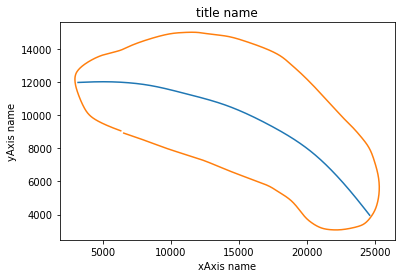

In [3]:
import matplotlib.pyplot as plt

plt.plot(x_mid,y_mid)
plt.plot(x_edg,y_edg)

plt.title('title name')
plt.xlabel('xAxis name')
plt.ylabel('yAxis name')
plt.show()

In [4]:
# From a midline and an edge, give as output
midline_final = aggregate_segment_char(x_mid, y_mid, 
                                       x_edg, y_edg, 
                                       n_midline_seg = 50, 
                                       n_sub_segment = 25, 
                                       n_edge_seg = 200)

SEGMENT IDX: 0, SUB_SEGMENT IDX: 0
180 left
186 right
SEGMENT IDX: 0, SUB_SEGMENT IDX: 1
180 left
186 right
SEGMENT IDX: 0, SUB_SEGMENT IDX: 2
180 left
186 right
SEGMENT IDX: 0, SUB_SEGMENT IDX: 3
180 left
186 right
SEGMENT IDX: 0, SUB_SEGMENT IDX: 4
180 left
186 right
SEGMENT IDX: 0, SUB_SEGMENT IDX: 5
179 left
186 right
SEGMENT IDX: 0, SUB_SEGMENT IDX: 6
179 left
187 right
SEGMENT IDX: 0, SUB_SEGMENT IDX: 7
179 left
187 right
SEGMENT IDX: 0, SUB_SEGMENT IDX: 8
179 left
187 right
SEGMENT IDX: 0, SUB_SEGMENT IDX: 9
179 left
187 right
SEGMENT IDX: 0, SUB_SEGMENT IDX: 10
179 left
187 right
SEGMENT IDX: 0, SUB_SEGMENT IDX: 11
179 left
188 right
SEGMENT IDX: 0, SUB_SEGMENT IDX: 12
179 left
188 right
SEGMENT IDX: 0, SUB_SEGMENT IDX: 13
179 left
188 right
SEGMENT IDX: 0, SUB_SEGMENT IDX: 14
179 left
188 right
SEGMENT IDX: 0, SUB_SEGMENT IDX: 15
179 left
188 right
SEGMENT IDX: 0, SUB_SEGMENT IDX: 16
178 left
188 right
SEGMENT IDX: 0, SUB_SEGMENT IDX: 17
178 left
188 right
SEGMENT IDX: 0, SUB_

In [ ]:
for a_centriole in a_list_of_centriole